In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import sys

import networkx as nx

sys.path.insert(0, 'gahyparopt/')

from gahyperopt import *

import ipywidgets as widgets
import os, shutil, shlex
import json, io
from subprocess import Popen, PIPE, STDOUT
from contextlib import redirect_stdout, redirect_stderr
from datetime import datetime
import pandas
import matplotlib as mpl
from matplotlib import pyplot
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
import glob
from collections import OrderedDict
import numpy

from GAUtilities import *

from parameters import *

In [18]:
import tensorflow as tf

In [19]:
tf.config.list_physical_devices('GPU') 

[]

In [5]:
def load_population():
    json_fnames = glob.glob("*.json")
    population = []
    names = []
    for j in json_fnames:
        name = j.split(".")[0]
        names.append(name)
        individuum = read_chromosome(j.split('.')[0])
        population.append(individuum)
        
    population = OrderedDict(zip(names, population))
    population=OrderedDict(sorted(population.items(),key=lambda x: x[1].accuracy, reverse=True))
    return population

In [6]:
POPULATION_SIZE=8

In [7]:
ga=GADriver(
            layer_counts=HIDDEN_LAYER_COUNT,
            no_neurons=HIDDEN_LAYER_NEURONS,
            rates=HIDDEN_LAYER_RATE,
            activations=HIDDEN_LAYER_ACTIVATIONS,
            layer_types=HIDDEN_LAYER_TYPE,
            optimizers=MODEL_OPTIMIZER,
            population_size=POPULATION_SIZE,
            best_candidates_count=BEST_CANDIDATES_COUNT,
            random_candidates_count=RANDOM_CANDIDATES_COUNT,
            optimizer_mutation_probability=OPTIMIZER_MUTATION_PROBABILITY,
            layer_mutation_probability=HIDDEN_LAYER_MUTATION_PROBABILITY,
        )

In [8]:
class model(object):
    generation_performance = {}
    population=None
    generations={}
    index=0

In [9]:
model = model()
model.population = load_population()

2022-02-18 12:39:47.148259: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2022-02-18 12:39:47.188266: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2100000000 Hz
2022-02-18 12:39:47.197546: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5584fad8a650 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-02-18 12:39:47.197598: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-02-18 12:39:47.197821: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
cmap = pyplot.cm.nipy_spectral  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey

# create the new map
segmented_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, POPULATION_SIZE)

segmented_cmap_list = [segmented_cmap(i) for i in range(segmented_cmap.N)]

# define the bins and normalize
bounds = np.linspace(0, POPULATION_SIZE, POPULATION_SIZE+1)
norm = mpl.colors.BoundaryNorm(bounds, POPULATION_SIZE)

players = model.population.keys()
color_player_dict = dict(zip(segmented_cmap_list, players))
player_color_dict = dict(zip(players, segmented_cmap_list))
# Add "0" for 0 generation
player_color_dict['0'] = "k"

In [11]:
def get_accuracy_plot(df):
    fig, ax = pyplot.subplots(2,1,sharex=True,figsize=(7,8))
    mn = df.accuracy.min()*0.9
    mx = min(df.accuracy.max()*1.1, 1.0)
    bar_width = 0.8
    df.iloc[::-1,::-1].plot.barh(x='name',
                                 y='accuracy',
                                 ax=ax[0],
                                 grid=True,
                                 color=color_player_dict
                                 )
    df['accuracy'].plot.hist(ax=ax[1],
                             grid=True,
                             bins=POPULATION_SIZE,
                             range=(mn,mx),
                             rwidth=bar_width,
                            )
    ax[1].set_xlim([mn,mx])
   
    return fig, ax


In [12]:
# Pull button
pull_button = widgets.Button(description="Generation aktualisieren")
def pull_button_clicked(b):
    log_widget.clear_output()
    with log_widget:
        sync_remote_to_local('all')
        
pull_button.on_click(pull_button_clicked)
#################################################################
#
# Generation count
generation_count = widgets.BoundedIntText(value=0, min=0, max=0)

def on_generation_count_change(change):
    log_widget.clear_output()
    with log_widget:
        df = model.generation_performance[change['new']]
        
    plot_accuracy_vs_name(df)
    plot_generation_tree()
    
generation_count.observe(on_generation_count_change, names=['value'])    
#################################################################
#
# Generation load button
generation_button = widgets.Button(description="Generation laden")

def generation_button_clicked(b):
    log_widget.clear_output()
    with log_widget:
        model.population = load_population()

        df = pandas.DataFrame([
            {'name': key,
             'loss': model.population[key].loss,
             'accuracy': model.population[key].accuracy
            } for key in model.population.keys()
        ])
        
        model.index = model.index + 1
        model.generation_performance.update({model.index: df})
        model.generations.update({model.index: model.population})
        generation_count.max = model.index
        generation_count.min = 1
        generation_count.value = model.index
    
generation_button.on_click(generation_button_clicked)
#################################################################
#
# Evolve button
evolve_button = widgets.Button(description="Evolution!")
def evolve_button_clicked(b):
    log_widget.clear_output()
    with log_widget:
        new_chromosomes = ga.evolve_population(list(model.population.values()))
        model.population = OrderedDict(zip(model.population.keys(), new_chromosomes))
        
evolve_button.on_click(evolve_button_clicked)
#################################################################
#
# Distribute button
distribute_button = widgets.Button(description="Generation verteilen")

def distribute_button_clicked(b):
    log_widget.clear_output()
    with log_widget:
        for name,individuum in model.population.items():
            write_chromosome(name=name,chromosome=individuum)
            sync_local_to_remote(name)
            
distribute_button.on_click(distribute_button_clicked)
#################################################################
#
# Plot widgets
accuracy_plot_widget = widgets.Output(layout={'border': '1px solid black', 'width':'50%', 'scroll':'true'})
generation_tree_widget = widgets.Output(layout={'border': '1px solid black', 'width':'50%', 'scroll':'true'})
log_widget = widgets.Output(layout={'border': '1px solid black', 'width':'80%', 'scroll':'true'})

def plot_accuracy_vs_name(df):
    accuracy_plot_widget.clear_output()
    with accuracy_plot_widget:
        
        fig, ax = get_accuracy_plot(df)

        show_inline_matplotlib_plots()
        
def plot_generation_tree():
    generation_tree_widget.clear_output()
    with generation_tree_widget:
        fig, ax = pyplot.subplots(1,1, figsize=(7,8))
        graph, pos = get_tree(model, generation_count.value)
        color = [player_color_dict[data["player"]] for v, data in graph.nodes(data=True)]
        nx.draw(graph, pos, ax, node_color=color)       
        show_inline_matplotlib_plots()
##################################################################
#
# GUI
gui = widgets.VBox(children=[
    widgets.HBox([pull_button, generation_button]),
    generation_count,
    widgets.HBox([
        accuracy_plot_widget,
        generation_tree_widget,
    ]),
    evolve_button,
    distribute_button,
    log_widget,
])

(<Figure size 504x576 with 2 Axes>,
 array([<AxesSubplot:ylabel='name'>, <AxesSubplot:ylabel='Frequency'>],
       dtype=object))

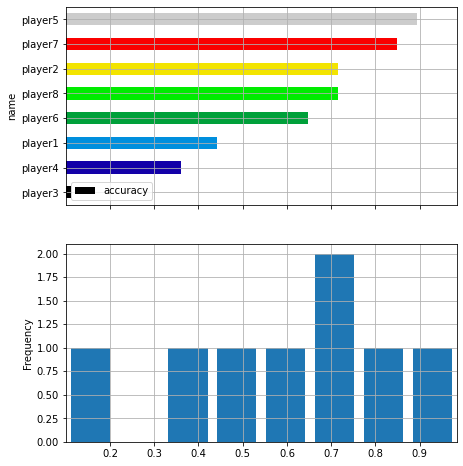

In [13]:
df = pandas.DataFrame([
    {'name': key,
     'loss': model.population[key].loss,
     'accuracy': model.population[key].accuracy
    } for key in model.population.keys()
])

get_accuracy_plot(df)

In [16]:
display(gui)

In [15]:
# Build graph
def get_tree(model, max_generation):
    
    graph = nx.DiGraph()
    graph.add_node("X-0", layer=0, player="0")
    
    for g,generation in model.generations.items():
        
        if g > max_generation:
            break
        for player, chrm in generation.items():
            graph.add_node("{}-{}".format(chrm.id, g), layer=g, player=player)


    edges = []

    for g,generation in model.generations.items():
        if g > max_generation:
            break
            
        for chrm in generation.values():
            parent_a = chrm.parent_a
            parent_b = chrm.parent_b
            id = chrm.id

            if parent_a is None and parent_b is None:
                parent_a = id
                parent_b = id

            if g == 1:
                parent_a = "X"
                parent_b = "X"

            parent_a = "{}-{}".format(parent_a, g-1) 
            parent_b = "{}-{}".format(parent_b, g-1) 

            if parent_a not in graph.nodes:
                parent_a = "{}-{}".format(id, g-1)
            if parent_b not in graph.nodes:
                parent_b = "{}-{}".format(id, g-1)

            id = "{}-{}".format(id, g)

            edges.append((parent_a, id))
            edges.append((parent_b, id))


    graph.add_edges_from(edges)

    nodes_to_remove = []
    for node,data in graph.nodes(data=True):
        if "layer" not in data.keys():
            nodes_to_remove.append(node)

    assert len(nodes_to_remove) == 0

    pos = nx.multipartite_layout(graph, subset_key="layer")

    return graph,pos

In [18]:
model.generations

{}

In [17]:
graph, pos = get_tree(model, 1)

In [18]:
graph.nodes(data=True)

NodeDataView({'X-0': {'layer': 0, 'player': '0'}})

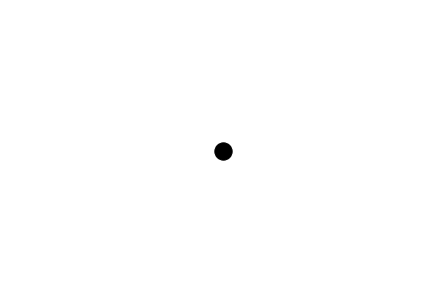

In [19]:
color = [player_color_dict[data["player"]] for v, data in graph.nodes(data=True)]
nx.draw(graph, pos, node_color=color)

In [20]:
graph.nodes(data=True)

NodeDataView({'X-0': {'layer': 0, 'player': '0'}})

In [21]:
for g,generation in model.generations.items():
    print("Generation {}".format(g))
    for name,chromosome in generation.items():
        print("\t",name, chromosome.accuracy, chromosome.id, chromosome.parent_a, chromosome.parent_b)

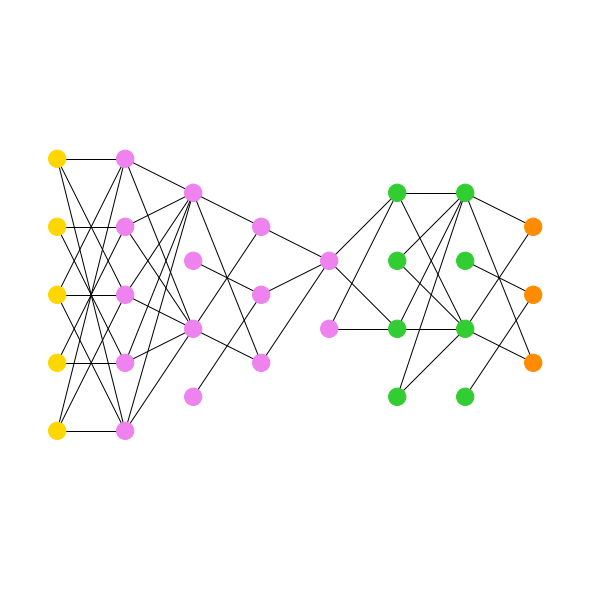

In [22]:
import itertools
import matplotlib.pyplot as plt
import networkx as nx

subset_sizes = [5, 5, 4, 3, 2, 4, 4, 3]
subset_color = [
    "gold",
    "violet",
    "violet",
    "violet",
    "violet",
    "limegreen",
    "limegreen",
    "darkorange",
]


def multilayered_graph(*subset_sizes):
    extents = nx.utils.pairwise(itertools.accumulate((0,) + subset_sizes))
    layers = [range(start, end) for start, end in extents]
    G = nx.Graph()
    for (i, layer) in enumerate(layers):
        G.add_nodes_from(layer, layer=i)
    for layer1, layer2 in nx.utils.pairwise(layers):
        edges = itertools.product(layer1, layer2)
        edges = [edge for i,edge in enumerate(edges) if i%2==0]
        G.add_edges_from(edges)
    return G


G = multilayered_graph(*subset_sizes)
color = [subset_color[data["layer"]] for v, data in G.nodes(data=True)]
pos = nx.multipartite_layout(G, subset_key="layer")
plt.figure(figsize=(8, 8))
nx.draw(G, pos, node_color=color, with_labels=False)
plt.axis("equal")
plt.show()

In [23]:
G.nodes(data=True)

NodeDataView({0: {'layer': 0}, 1: {'layer': 0}, 2: {'layer': 0}, 3: {'layer': 0}, 4: {'layer': 0}, 5: {'layer': 1}, 6: {'layer': 1}, 7: {'layer': 1}, 8: {'layer': 1}, 9: {'layer': 1}, 10: {'layer': 2}, 11: {'layer': 2}, 12: {'layer': 2}, 13: {'layer': 2}, 14: {'layer': 3}, 15: {'layer': 3}, 16: {'layer': 3}, 17: {'layer': 4}, 18: {'layer': 4}, 19: {'layer': 5}, 20: {'layer': 5}, 21: {'layer': 5}, 22: {'layer': 5}, 23: {'layer': 6}, 24: {'layer': 6}, 25: {'layer': 6}, 26: {'layer': 6}, 27: {'layer': 7}, 28: {'layer': 7}, 29: {'layer': 7}})

In [24]:
graph.nodes(data=True)

NodeDataView({'X-0': {'layer': 0, 'player': '0'}})

In [25]:
pos = nx.multipartite_layout(graph, subset_key='generation')

ValueError: all nodes must have subset_key (default='subset') as data

In [ ]:
graph.nodes

In [ ]:
load_population()

In [ ]:
model.population

In [ ]:
for pl, ind in model.population.items():
    print(pl, ind.parent_a, ind.parent_b, ind.id)
    #ind.ml_model.summary()

In [ ]:
import newick

In [ ]:
# Generate tree
initial_population = model.generations[1]

In [ ]:
initial_population

In [ ]:
last_generation = model.generations[next(reversed(model.generations.keys()))]

In [ ]:
last_generation

In [ ]:
# Reverse-iterate through the generations and build up the tree.

In [ ]:
chromosome=  last_generation['spieler4']

In [ ]:
del model.generations[0]

In [ ]:
root = newick.Node.create(name="X")
# for gen in model.generations.values:
for indvdl_gen1 in model.generations[1].values():
    node_gen1 = newick.Node.create(name=indvdl_gen1.id)
    for indvdl_gen2 in model.generations[2].values():
        if indvdl_gen2.parent_a == indvdl_gen1.id:
            node_gen1.add_descendant(newick.Node.create(name=indvdl_gen2.id))
        elif indvdl_gen2.parent_b == indvdl_gen1.id:
            node_gen1.add_descendant(newick.Node.create(name=indvdl_gen2.id))
        elif indvdl_gen2.id == indvdl_gen1.id:
            node_gen1.add_descendant(newick.Node.create(name=indvdl_gen2.id))
            
#     parent_a = newick.Node.create(name=indvdl.parent_a)
#     parent_b = newick.Node.create(name=indvdl.parent_b)

#     node.add_descendant(parent_a)
#     node.add_descendant(parent_b)
    
    root.add_descendant(node_gen1)
    
    

In [ ]:
print(root.ascii_art())

In [ ]:
winner = newick.Node.create(name=next(reversed(model.generations)), descendants=None)

In [ ]:
for gen, pop in model.generations:
    
root.add_descendant(newick.Node(name='A'))

In [ ]:
model.generations[4]

In [ ]:
generation_count.value

In [ ]:
winner = model.generations[4]['B']; winner

In [ ]:
for gen in range(4,0,-1):
    for parent in 
    winner_node.add_descendant(parent.id)

In [ ]:
winner_node = newick.Node(name=winner.id)

In [ ]:
def add_parents(node, parent_gen):
    gen_dict = model.generations[parent_gen]
    chromosomes = list(gen_dict.values())
    
    parent_ids = 
    node.add_descendant()
    
    
    

In [ ]:
for gen, pop in model.generations.items():
    print(gen)
    if gen>0:
        print(pop['D'].id)
          

In [ ]:
model.generations